In [1]:
# imports

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
# train_df = pd.read_csv("../data/transformed/train_outliers_removed.csv", index_col=0)
train_df = pd.read_csv("../data/transformed/train_outliers_removed.csv", index_col=0)
original_df = pd.read_csv("../data/transformed/original_outliers_removed.csv")
test_df = pd.read_csv("../data/input/test.csv", index_col=0)

train_df['source'] = 'train'
original_df['source'] = 'original'

# train_df = train_df[train_df.age > 2]

In [3]:
# Handling duplicates
cols = ["length", "diameter", "height", "weight", "shucked_weight", "viscera_weight", "shell_weight", "age"]

df = pd.concat([train_df, original_df])

grp = df.groupby(cols)['source']

df['source_cnt'] = grp.transform(lambda x: len(set(x)))

In [4]:
# Records exists in both train and original
unique_records = df[df['source_cnt'] == 1]
records_to_keep_from_dups = df[(df['source_cnt'] > 1) & (df['source'] == 'original')]


unique_df = pd.concat([unique_records, records_to_keep_from_dups])

df.shape[0] - unique_df.shape[0]

162

In [5]:
grp1 = unique_df.groupby(cols)['sex']

unique_df['sex_cnt'] = grp1.transform(lambda x: len(set(x)))

In [6]:
unique_df1 = unique_df[(unique_df['sex_cnt'] == 1)]

unique_df1 = unique_df1.drop(['source', 'sex_cnt', 'source_cnt'], axis = 1)

In [7]:
df.shape[0] - unique_df1.shape[0]

267

## Train Test Split

In [8]:
df = unique_df1.copy()

target = 'age'
features = df.columns.drop(target).tolist()

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Feature Engineering

#### Encode sex values

In [9]:
from sklearn.preprocessing import OneHotEncoder

oh_encoder = OneHotEncoder(sparse_output=True, dtype='int')
oh_encoder.fit(X_train[['sex']])

sex_columns = ["sex" + "_" + col for col in oh_encoder.categories_[0]]

X_train[sex_columns] = oh_encoder.transform(X_train[['sex']]).toarray()
X_train = X_train.drop('sex', axis = 1)

X_test[sex_columns] = oh_encoder.transform(X_test[['sex']]).toarray()
X_test = X_test.drop('sex', axis = 1)

#### Feature Scaling

In [10]:
from sklearn.preprocessing import RobustScaler

columns_to_scale = ['length', 'diameter', 'height', 'weight', 'shucked_weight', 'viscera_weight', 'shell_weight']

scaler = RobustScaler()
scaler.fit(X_train[columns_to_scale])


X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

## Modelling

In [11]:
def evaluate(model, train, test):    
    X_train, y_train = train
    X_test, y_test = test
    
    y_train_predicted = model.predict(X_train)
    y_test_predicted = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_train_predicted)
    test_mae = mean_absolute_error(y_test, y_test_predicted)

    print(f"Train MAE: {train_mae}")
    print(f"Test MAE: {test_mae}")

### Model

#### Linear Regressor

In [12]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

evaluate(lr, (X_train, y_train), (X_test, y_test))

Train MAE: 1.4894812773311314
Test MAE: 1.4684874449574559


#### Random Forest Regressor

In [13]:
from sklearn.ensemble import RandomForestRegressor

rfr_default = RandomForestRegressor()

rfr_default.fit(X_train, y_train)

# overfitting
evaluate(rfr_default, (X_train, y_train), (X_test, y_test))

Train MAE: 0.5555007268696823
Test MAE: 1.4618114138658078


In [14]:
rfr1 = RandomForestRegressor(max_leaf_nodes=90)

rfr1.fit(X_train, y_train)

evaluate(rfr1, (X_train, y_train), (X_test, y_test))

Train MAE: 1.414116908021466
Test MAE: 1.4212457191809567


In [15]:
rfr2 = RandomForestRegressor(max_leaf_nodes=150)

rfr2.fit(X_train, y_train)

evaluate(rfr2, (X_train, y_train), (X_test, y_test))

Train MAE: 1.3917928522379504
Test MAE: 1.412676095548001


#### Gradient Boosting Regressor

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_default = GradientBoostingRegressor()

gbr_default.fit(X_train, y_train)

evaluate(gbr_default, (X_train, y_train), (X_test, y_test))

Train MAE: 1.4163529586208565
Test MAE: 1.4095763330400861


In [17]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_1 = GradientBoostingRegressor(max_depth=4)

gbr_1.fit(X_train, y_train)

evaluate(gbr_1, (X_train, y_train), (X_test, y_test))

Train MAE: 1.3919540012282718
Test MAE: 1.3959411223130493


#### HistGradientBoostingRegressor

In [18]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgbr = HistGradientBoostingRegressor(loss = 'absolute_error')

hgbr.fit(X_train, y_train)

evaluate(hgbr, (X_train, y_train), (X_test, y_test))

Train MAE: 1.3600819360376541
Test MAE: 1.3643087189947976


In [19]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgbr_1 = HistGradientBoostingRegressor(
    loss = 'absolute_error', 
    l2_regularization = 0.01,
    max_depth=5, 
    max_iter=500,
    random_state=42)

hgbr_1.fit(X_train, y_train)

evaluate(hgbr_1, (X_train, y_train), (X_test, y_test))

Train MAE: 1.3542088772034733
Test MAE: 1.3598284710619022


#### Stacking Regressor

In [20]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

sr = StackingRegressor(
    [('rfr2', rfr2), ("gbr_1", gbr_1), ('hgbr', hgbr)], 
    final_estimator=Ridge(), 
    cv = 'prefit')

sr.fit(X_train, y_train)

evaluate(sr, (X_train, y_train), (X_test, y_test))

Train MAE: 1.39628357080875
Test MAE: 1.4213175418692716


#### Deep Learning Model (Flatten Model)

In [21]:
import keras
from keras import layers, optimizers, callbacks, regularizers

dl_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=(X_train.shape[1])),
        layers.Dense(5, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(3, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1)
    ]
)

dl_model.compile(
    optimizer = optimizers.Adam(learning_rate = 0.001),
    loss = 'mae'
)

model_callbacks = [
    callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True
    )
]

history = dl_model.fit(
    X_train, 
    y_train, 
    batch_size = 128, 
    epochs = 100,
    validation_data = (X_test, y_test), 
    callbacks = model_callbacks,
    workers = 2
)

Epoch 1/100
477/477 [==============================] - 3s 4ms/step - loss: 8.7751 - val_loss: 6.6767
Epoch 2/100
477/477 [==============================] - 1s 3ms/step - loss: 4.3264 - val_loss: 2.0800
Epoch 3/100
477/477 [==============================] - 1s 3ms/step - loss: 1.5220 - val_loss: 1.4536
Epoch 4/100
477/477 [==============================] - 1s 3ms/step - loss: 1.4726 - val_loss: 1.4368
Epoch 5/100
477/477 [==============================] - 1s 3ms/step - loss: 1.4633 - val_loss: 1.4222
Epoch 6/100
477/477 [==============================] - 1s 3ms/step - loss: 1.4586 - val_loss: 1.4123
Epoch 7/100
477/477 [==============================] - 1s 3ms/step - loss: 1.4515 - val_loss: 1.4061
Epoch 8/100
477/477 [==============================] - 1s 3ms/step - loss: 1.4507 - val_loss: 1.4067
Epoch 9/100
477/477 [==============================] - 1s 3ms/step - loss: 1.4492 - val_loss: 1.4006
Epoch 10/100
477/477 [==============================] - 1s 3ms/step - loss: 1.4427 - val_lo

In [22]:
dl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 55        
                                                                 
 batch_normalization (BatchN  (None, 5)                20        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
 batch_normalization_1 (Batc  (None, 3)                12        
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 109
Trainable params: 93
Non-trainable par

In [23]:
evaluate(dl_model, (X_train, y_train), (X_test, y_test))

477/477 [==============================] - 1s 2ms/step
Train MAE: 1.398093918343461
Test MAE: 1.3752151057300182


[Text(0.5, 1.0, 'Epoch vs Loss'),
 Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Loss (MAE)')]

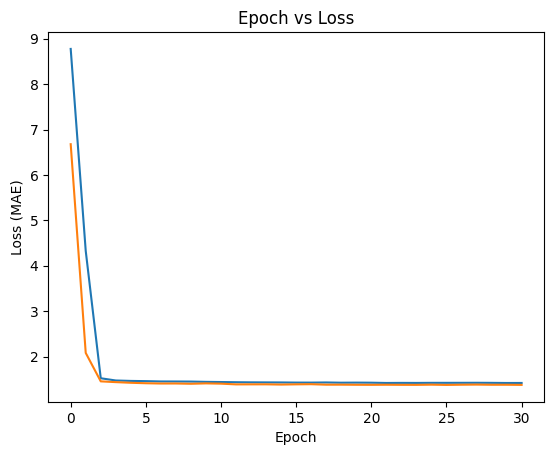

In [24]:
axs = plt.axes()
axs.plot(history.history['loss'], label = 'train-loss')
axs.plot(history.history['val_loss'], label = 'val-loss')
axs.set(title = 'Epoch vs Loss', xlabel = 'Epoch', ylabel = 'Loss (MAE)')

#### Deep Learning Model (1D-CNN Model)

In [25]:
X_train_reshaped = X_train.to_numpy().reshape(-1, 10, 1)
X_test_reshaped = X_test.to_numpy().reshape(-1, 10, 1)

In [26]:
import keras
from keras import layers, optimizers, callbacks, regularizers

dl_cnn_model = keras.Sequential(
    [
        layers.InputLayer(input_shape= X_train_reshaped.shape[1:]),
        layers.Conv1D(filters = 64, kernel_size = 3, activation='relu'),
        layers.Conv1D(filters = 32, kernel_size = 3, activation='relu'),
        layers.Conv1D(filters = 16, kernel_size = 3, activation='relu'),
        layers.GlobalAveragePooling1D(), 
        layers.Flatten(),
        layers.Dense(5, activation='relu'),
        layers.Dense(1)
    ]
)

dl_cnn_model.summary()

dl_cnn_model.compile(
    optimizer = optimizers.Adam(learning_rate = 0.001),
    loss = 'mae'
)

model_callbacks = [
    callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True
    )
]

history = dl_cnn_model.fit(
    X_train, 
    y_train, 
    batch_size = 128, 
    epochs = 100,
    validation_data = (X_test, y_test), 
    callbacks = model_callbacks,
    workers = 2
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 64)             256       
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 32)             6176      
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 16)             1552      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                      

In [27]:
evaluate(dl_cnn_model, (X_train, y_train), (X_test, y_test))

477/477 [==============================] - 2s 4ms/step
Train MAE: 1.4044706425570492
Test MAE: 1.3855232358698646


[Text(0.5, 1.0, 'Epoch vs Loss'),
 Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Loss (MAE)')]

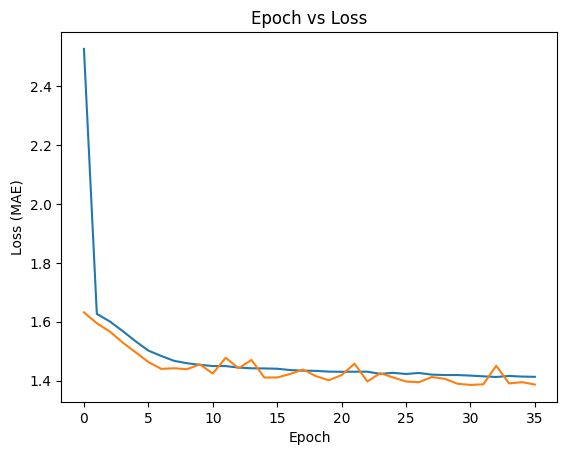

In [28]:
axs = plt.axes()
axs.plot(history.history['loss'], label = 'train-loss')
axs.plot(history.history['val_loss'], label = 'val-loss')
axs.set(title = 'Epoch vs Loss', xlabel = 'Epoch', ylabel = 'Loss (MAE)')

## Predict on Test Unseen

In [29]:
X_test_unseen = test_df.copy()
X_test_unseen.columns = features

X_test_unseen[sex_columns] = oh_encoder.transform(X_test_unseen[['sex']]).toarray()
X_test_unseen = X_test_unseen.drop('sex', axis = 1)

X_test_unseen[columns_to_scale] = scaler.transform(X_test_unseen[columns_to_scale])

# Deep CNN Transformation input
X_test_unseen_reshaped = X_test_unseen.to_numpy().reshape(-1, 10, 1)

In [30]:
from datetime import datetime

model = hgbr_1
model_name = "hgbr_1"

now = datetime.now().strftime("%Y%m%d_%H%M%S")

output = pd.read_csv("../data/input/sample_submission.csv", index_col=0)
output['Age'] = model.predict(X_test_unseen)

# output.to_csv(f"../data/output/crab_age_{model_name}_{now}.csv", index=True)